# HIT140 A3 — Clean Inline Notebook (Investigation A & B)

**Weeks 1–9 compliant; inline outputs only.**  
Place `dataset1.csv` and `dataset2.csv` in the **same folder** as this notebook, or edit the paths below.


In [167]:
#libraries used for data analysis and visualization
import pandas as pd # for data manipulation and analysis
import matplotlib.pyplot as plt  ## for plotting graph
import numpy as np   ## for numerical operation
import seaborn as sns ## for enhanced visualizations
from scipy.stats import mannwhitneyu, chi2_contingency, norm, skew  # For statistical tests
from statsmodels.stats.proportion import proportion_confint  # For proportion confidence intervals

In [168]:

# for linear regression
HAVE_SKLEARN = False
HAVE_STATSMODELS = False
try:
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import StandardScaler, PowerTransformer
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    HAVE_SKLEARN = True
except Exception:
    pass

try:
    import statsmodels.api as sm
    HAVE_STATSMODELS = True
except Exception:
    pass

print('Libraries imported successfully')

Libraries imported successfully


In [169]:
# Set seaborn style
sns.set(style="whitegrid")

In [170]:
# location of datasets
DATASET1_PATH = 'dataset1.csv'
DATASET2_PATH = 'dataset2.csv'

print('dataset1:', DATASET1_PATH)
print('dataset2:', DATASET2_PATH)

dataset1: dataset1.csv
dataset2: dataset2.csv


In [171]:
# Read data
dataset1 = pd.read_csv('dataset1.csv')
dataset2 = pd.read_csv('dataset2.csv')

In [172]:
# === HELPERS ===
# These utility functions modularise common EDA and regression analysis tasks,
# supporting clarity, maintainability, and scientific reproducibility.

def cast_numeric(df, columns):
    """Safely cast listed columns to numeric (coerce errors to NaN)."""
    for col in columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def add_intercept(X):
    return np.column_stack([np.ones(len(X)), X])

def numpy_ols(y, X, feature_names):
    """Multiple Linear Regression via NumPy least squares."""
    if X.size == 0 or y.size == 0:
        print('Empty X or y.'); 
        return None
    data_concat = np.column_stack([y] + [X[:, i] for i in range(X.shape[1])])
    row_mask = ~np.isnan(data_concat).any(axis=1)
    y_clean = y[row_mask].astype(float)
    X_clean = X[row_mask, :].astype(float)
    if len(y_clean) < X_clean.shape[1] + 2:
        print('Insufficient rows to fit model.'); 
        return None
    Xd = add_intercept(X_clean)
    beta, residuals, rank, s = np.linalg.lstsq(Xd, y_clean, rcond=None)
    y_hat = Xd @ beta
    ss_res = np.sum((y_clean - y_hat) ** 2)
    ss_tot = np.sum((y_clean - np.mean(y_clean)) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else float('nan')
    n = len(y_clean); p = X_clean.shape[1]
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1) if (n - p - 1) > 0 else float('nan')
    rmse = math.sqrt(ss_res / n) if n > 0 else float('nan')
    coef_df = pd.DataFrame({'term': ['intercept'] + feature_names, 'coefficient': beta.tolist()})
    return {'beta': beta, 'r2': r2, 'adj_r2': adj_r2, 'rmse': rmse, 'n': n, 'p': p, 'yhat': y_hat, 'y': y_clean, 'coef_df': coef_df}

def show_correlation_heatmap(df, cols, title='Correlation heatmap'):
    if len(cols) < 2:
        print('Need >= 2 columns for a correlation heatmap.'); 
        return
    corr = df[cols].corr()
    print('Correlation matrix:')
    display(corr)
    plt.figure()
    plt.imshow(corr.values, aspect='auto')
    plt.xticks(range(len(cols)), cols, rotation=30, ha='right')
    plt.yticks(range(len(cols)), cols)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def show_coef_bar(coef_df, title='Coefficients'):
    df = coef_df[coef_df['term'] != 'intercept'].copy()
    if df.empty:
        print('No coefficients (other than intercept) to display.'); 
        return
    plt.figure()
    plt.bar(df['term'], df['coefficient'])
    plt.title(title); plt.ylabel('Coefficient')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout(); plt.show()

def show_residual_hist(residuals, title='Residuals', xlabel='Residual'):
    plt.figure()
    plt.hist(residuals, bins=30)
    plt.title(title); plt.xlabel(xlabel)
    plt.tight_layout(); plt.show()

def show_fitted_vs_observed(y_hat, y, title='Fitted vs Observed'):
    plt.figure()
    plt.scatter(y_hat, y, s=12)
    plt.title(title); plt.xlabel('Fitted'); plt.ylabel('Observed')
    plt.tight_layout(); plt.show()

## 1) Load & Clean

In [173]:
# EDA for  Dataset 1

print("\n Dataset information")
dataset1.info()   # show data type

print("\n Statistiacal summary ")
print(dataset1.describe())  # provides Summary  stats for numeric columns 

print("\nMissing values:")
print(dataset1.isnull().sum()) # provides total count of missing values


 Dataset information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907 entries, 0 to 906
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   start_time                 907 non-null    object 
 1   bat_landing_to_food        907 non-null    float64
 2   habit                      866 non-null    object 
 3   rat_period_start           907 non-null    object 
 4   rat_period_end             907 non-null    object 
 5   seconds_after_rat_arrival  907 non-null    int64  
 6   risk                       907 non-null    int64  
 7   reward                     907 non-null    int64  
 8   month                      907 non-null    int64  
 9   sunset_time                907 non-null    object 
 10  hours_after_sunset         907 non-null    float64
 11  season                     907 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 85.2+ KB

 Statistiacal summary 
  

In [174]:
# EDA for  Dataset 2

print("\n Dataset information")
dataset2.info()   # show data type

print("\n Statistiacal summary ")
print(dataset2.describe())  # provides Summary  stats for numeric columns 

print("\nMissing values:")
print(dataset2.isnull().sum()) # provides total count of missing values


 Dataset information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2123 entries, 0 to 2122
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   time                2123 non-null   object 
 1   month               2123 non-null   int64  
 2   hours_after_sunset  2123 non-null   float64
 3   bat_landing_number  2123 non-null   int64  
 4   food_availability   2123 non-null   float64
 5   rat_minutes         2123 non-null   float64
 6   rat_arrival_number  2123 non-null   int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 116.2+ KB

 Statistiacal summary 
             month  hours_after_sunset  bat_landing_number  food_availability  \
count  2123.000000         2123.000000         2123.000000        2123.000000   
mean      3.083844            5.265426           32.083373           2.445874   
std       1.642261            4.076188           25.614431           1.218353   
min       0.000000 

In [175]:
## Data Preprocessing
## check for any duplicate vaules in dataset 
print(f'There are {dataset1.duplicated().sum()} duplicate rows in dataset 1.')
print(f'There are {dataset2.duplicated().sum()} duplicate rows in dataset 2.')

There are 1 duplicate rows in dataset 1.
There are 0 duplicate rows in dataset 2.


In [176]:
# Remove duplicates
# Remove duplicate rows 
dataset1 = dataset1.drop_duplicates()
dataset2 = dataset2.drop_duplicates()

In [177]:
## checking for any messing  value data set 1 and 2 
print(dataset1.isna().sum())
print(dataset2.isna().sum())

start_time                    0
bat_landing_to_food           0
habit                        41
rat_period_start              0
rat_period_end                0
seconds_after_rat_arrival     0
risk                          0
reward                        0
month                         0
sunset_time                   0
hours_after_sunset            0
season                        0
dtype: int64
time                  0
month                 0
hours_after_sunset    0
bat_landing_number    0
food_availability     0
rat_minutes           0
rat_arrival_number    0
dtype: int64


In [178]:
#41 data are missing form habit column
#Handle Missing Values
# Check and address missing values in quantitative and qualitative variables to ensure data completeness
# bat_landing_to_food, seconds_after_rat_arrival, hours_after_sunset
for col in ['bat_landing_to_food', 'seconds_after_rat_arrival', 'hours_after_sunset']:
    if dataset1[col].isnull().sum() > 0:
        print(f"Missing values in dataset1.{col}: {dataset1[col].isnull().sum()}")
        if col == 'bat_landing_to_food':
            # Drop rows with missing bat_landing_to_food, as it's critical for vigilance analysis
            dataset1 = dataset1.dropna(subset=[col])
        elif col == 'seconds_after_rat_arrival':
            # Missing seconds_after_rat_arrival indicates no rat was present; leave as is
            pass
        elif col == 'hours_after_sunset':
            # replace with median of same month to preserve temporal patterns
            dataset1[col] = dataset1.groupby('month')[col].transform(lambda x: x.fillna(x.median()))

habit is missing 41 column data in data set 1
The below code focuses on identifying and addressing missing values in these columns, with specific handling for the habit column (imputing with 'unknown') and different handling for risk and reward (dropping rows). It also includes diagnostic checks to explore whether missing habit values are related to key variables like bat_landing_to_food or rat presence (seconds_after_rat_arrival).

In [179]:
# Qualitative columns missing values replace with unknown
for col in ['risk', 'reward', 'habit']:
    if col in dataset1.columns and dataset1[col].isnull().sum() > 0:
        print(f"Missing values in dataset1.{col}: {dataset1[col].isnull().sum()}")
        if col == 'habit':
            # replace missing habit with 'unknown'
            print(f"Imputing {dataset1[col].isnull().sum()} missing habit values with 'unknown'")
            dataset1[col] = dataset1[col].fillna('unknown')

            # check for other missing values
            missing_habit = dataset1[dataset1[col].isna()] 
            if not missing_habit.empty:
                print("Descriptive stats for bat_landing_to_food in rows with missing habit:")
                print(missing_habit['bat_landing_to_food'].describe())
                print("Rat presence in rows with missing habit:")
                print(missing_habit['seconds_after_rat_arrival'].notnull().value_counts())
        else:
            # Drop rows with missing risk or reward
            dataset1 = dataset1.dropna(subset=[col])

Missing values in dataset1.habit: 41
Imputing 41 missing habit values with 'unknown'


In [180]:
# Quantitative (dataset2): bat_landing_number, food_availability, rat_minutes, rat_arrival_number, hours_after_sunset
for col in ['bat_landing_number', 'food_availability', 'rat_minutes', 'rat_arrival_number', 'hours_after_sunset']:
    if dataset2[col].isnull().sum() > 0:
        print(f"Missing values in dataset2.{col}: {dataset2[col].isnull().sum()}")
        if col == 'food_availability':
            # Impute with median of same month to account for seasonal patterns
            dataset2[col] = dataset2.groupby('month')[col].transform(lambda x: x.fillna(x.median()))
        elif col in ['rat_minutes', 'rat_arrival_number']:
            # Assume 0 for missing rat presence (no rats in that period)
            dataset2[col] = dataset2[col].fillna(0)
        else:
            # Drop rows with missing bat_landing_number or hours_after_sunset
            dataset2 = dataset2.dropna(subset=[col])

In [181]:
## checking for any messing  value data set 1
print(dataset1.isna().sum())

start_time                   0
bat_landing_to_food          0
habit                        0
rat_period_start             0
rat_period_end               0
seconds_after_rat_arrival    0
risk                         0
reward                       0
month                        0
sunset_time                  0
hours_after_sunset           0
season                       0
dtype: int64


In [182]:
## checking for any messing  value data set 2
print(dataset2.isna().sum())

time                  0
month                 0
hours_after_sunset    0
bat_landing_number    0
food_availability     0
rat_minutes           0
rat_arrival_number    0
dtype: int64


In [183]:

# Datetime casting
# Convert time columns with day first style
for col in ['start_time', 'rat_period_start', 'rat_period_end', 'sunset_time']:
    if col in dataset1.columns:
        dataset1[col] = pd.to_datetime(dataset1[col], errors='coerce', dayfirst=True)

if 'time' in dataset2.columns:
    dataset2['time'] = pd.to_datetime(dataset2['time'], errors='coerce', dayfirst=True)


# Numeric casting
dataset1 = cast_numeric(dataset1, ['bat_landing_to_food','seconds_after_rat_arrival','hours_after_sunset','risk','reward'])
dataset2 = cast_numeric(dataset2, ['bat_landing_number','food_availability','rat_minutes','rat_arrival_number','hours_after_sunset'])

print('Dataset 1 — Data Types:')
display(dataset1.dtypes.to_frame('dtype').T)
print('\n')
print('Dataset 2 — data Types:')
display(dataset2.dtypes.to_frame('dtype').T)

Dataset 1 — Data Types:


,start_time,bat_landing_to_food,habit,rat_period_start,rat_period_end,seconds_after_rat_arrival,risk,reward,month,sunset_time,hours_after_sunset,season
dtype,datetime64[ns],float64,object,datetime64[ns],datetime64[ns],int64,int64,int64,int64,datetime64[ns],float64,int64




Dataset 2 — data Types:


,time,month,hours_after_sunset,bat_landing_number,food_availability,rat_minutes,rat_arrival_number
dtype,datetime64[ns],int64,float64,int64,float64,float64,int64


## 2) Time-aware Merge (±30 minutes)

In [ ]:
# === TIME-AWARE MERGE BETWEEN DATASETS ===
# Combine bat (dataset1) and rat (dataset2) records based on their timestamps.
# This uses a ±30-minute tolerance to match the nearest rat observation for each bat event.
# The merge_asof approach is appropriate when both datasets are time-ordered and observations

# Check that both time columns exist before attempting the merge
if 'start_time' in dataset1.columns and 'time' in dataset2.columns:
    # Convert time columns to datetime to ensure consistency
    dataset1['start_time'] = pd.to_datetime(dataset1['start_time'], format='%d/%m/%Y %H:%M', errors='coerce')
    dataset2['time'] = pd.to_datetime(dataset2['time'], format='%d/%m/%Y %H:%M', errors='coerce')

    # Sort datasets by time to satisfy merge_asof() requirements
    dataset1_sorted = dataset1.sort_values('start_time')
    dataset2_sorted = dataset2.sort_values('time')

    # Perform a time-aware (nearest) merge within a 30-minute tolerance window
    # Drop hours_after_sunset from dataset2 to avoid duplicate columns
    merged_df = pd.merge_asof(
        dataset1_sorted,
        dataset2_sorted[
            ['time', 'rat_minutes', 'rat_arrival_number', 'bat_landing_number', 'food_availability']
        ],  # Exclude hours_after_sunset from dataset2
        left_on='start_time',      # main timestamp from dataset1 (bat events)
        right_on='time',           # timestamp from dataset2 (rat blocks)
        direction='nearest',       # match nearest observation (before or after)
        tolerance=pd.Timedelta('30min')  # maximum time difference allowed
    )

    # Create a flag showing which rows successfully found a matching rat block
    merged_df['has_block_match'] = merged_df['time'].notna()

# If one or both timestamp columns are missing, fall back to a simpler merge
else:
    print('Time-aware merge skipped — missing start_time/time columns. '
          'Falling back to simple merge on shared keys if available.')

    # Try to merge using common contextual columns (e.g., month, hours_after_sunset)
    shared_keys = [c for c in ['month', 'hours_after_sunset']
                   if c in dataset1.columns and c in dataset2.columns]

    if shared_keys:
        # If hours_after_sunset is in shared_keys, drop it from dataset2 to avoid duplicates
        dataset2_for_merge = dataset2.drop(columns=['hours_after_sunset'], errors='ignore')
        # Perform a standard key-based merge
        merged_df = pd.merge(dataset1, dataset2_for_merge, on=shared_keys, how='left')
        merged_df['has_block_match'] = merged_df['time'].notna() if 'time' in merged_df.columns else False
    else:
        # If no merge keys exist, continue with dataset1 only to preserve workflow
        print('No shared keys for merge. Using dataset1 only.')
        merged_df = dataset1.copy()
        merged_df['has_block_match'] = False



# Display merge results for verification
print('Merged shape:', merged_df.shape)  # shows number of rows × columns after merge
display(merged_df.head(5))               # preview first 5 rows for sanity check


Merged shape: (906, 18)


,start_time,bat_landing_to_food,habit,rat_period_start,rat_period_end,seconds_after_rat_arrival,risk,reward,month,sunset_time,hours_after_sunset,season,time,rat_minutes,rat_arrival_number,bat_landing_number,food_availability,has_block_match
0,2017-12-26 20:57:00,1.0,unknown,2017-12-26 20:53:00,2017-12-26 20:58:00,239,0,0,0,2017-12-26 16:43:00,4.248611,0,2017-12-26 20:43:00,1.283333,2,51,2.968874,True
1,2017-12-26 20:57:00,5.0,unknown,2017-12-26 20:53:00,2017-12-26 20:58:00,199,0,0,0,2017-12-26 16:43:00,4.237500,0,2017-12-26 20:43:00,1.283333,2,51,2.968874,True
2,2017-12-26 21:24:00,3.0,fast,2017-12-26 21:22:00,2017-12-26 21:27:00,121,0,1,0,2017-12-26 16:43:00,4.693611,0,2017-12-26 21:13:00,4.866667,1,53,2.561404,True
3,2017-12-26 21:24:00,15.0,rat,2017-12-26 21:22:00,2017-12-26 21:27:00,88,1,0,0,2017-12-26 16:43:00,4.684444,0,2017-12-26 21:13:00,4.866667,1,53,2.561404,True
4,2017-12-26 21:24:00,6.0,pick,2017-12-26 21:22:00,2017-12-26 21:27:00,113,0,1,0,2017-12-26 16:43:00,4.691389,0,2017-12-26 21:13:00,4.866667,1,53,2.561404,True


## 3) EDA & Multicollinearity Check

Target: bat_landing_to_food | Predictors: ['rat_minutes', 'rat_arrival_number', 'hours_after_sunset', 'food_availability', 'bat_landing_number']
Correlation matrix:


,rat_minutes,rat_arrival_number,hours_after_sunset,food_availability,bat_landing_number
rat_minutes,1.000000,0.421695,0.150291,-0.070872,-0.182713
rat_arrival_number,0.421695,1.000000,0.071410,-0.002841,-0.108188
hours_after_sunset,0.150291,0.071410,1.000000,-0.686291,-0.263500
food_availability,-0.070872,-0.002841,-0.686291,1.000000,0.025157
bat_landing_number,-0.182713,-0.108188,-0.263500,0.025157,1.000000


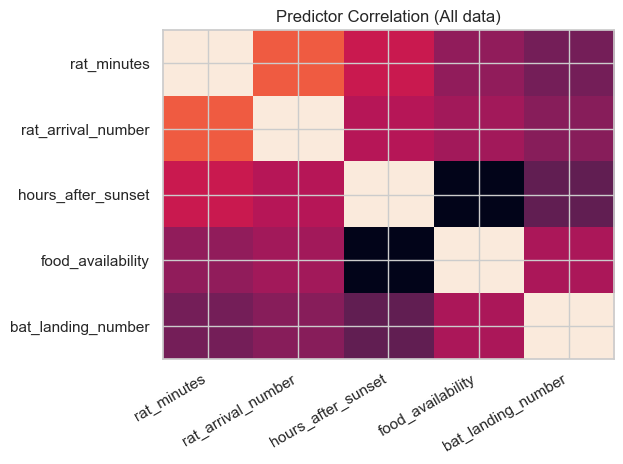

In [190]:
# Target and predictors
target_var = 'bat_landing_to_food'
candidate_predictors = ['rat_minutes','rat_arrival_number','hours_after_sunset','food_availability','bat_landing_number']
predictor_cols = [c for c in candidate_predictors if c in merged_df.columns]

print('Target:', target_var, '| Predictors:', predictor_cols)
if target_var not in merged_df.columns:
    print('Warning: target variable not found in merged data.')

# Correlation heatmap for predictors
if len(predictor_cols) >= 2:
    show_correlation_heatmap(merged_df, predictor_cols, title='Predictor Correlation (All data)')
else:
    print('Not enough predictors for correlation heatmap.')

# Feature Engineering

In [191]:
# Feature Engineering
# Create a binary rat_present column to simplify analysis (1 if rat was present, 0 otherwise)
merged_df['rat_present'] = merged_df['seconds_after_rat_arrival'].notnull() | (merged_df['rat_minutes'] > 0)

In [192]:
# Define rat-present and rat-absent groups for analysis
rat_present = merged_df[merged_df['rat_present']]
rat_absent = merged_df[merged_df['rat_present']]

In [193]:
# Descriptive Analysis of  Quantitative Variables
# Define quantitative variables to analyze from both datasets
quant_vars = {
    'dataset1': ['bat_landing_to_food', 'seconds_after_rat_arrival', 'hours_after_sunset'],
    'dataset2': ['bat_landing_number', 'food_availability', 'rat_minutes', 'rat_arrival_number']
   }


Descriptive Analysis for dataset1:

bat_landing_to_food:
  Mean: 11.72, Median: 4.00, Mode: 1.00
  Std Dev: 27.66, Range: 442.99, Variance: 765.01, IQR: 10.75
  Skewness: 7.66 (Right-skewed)


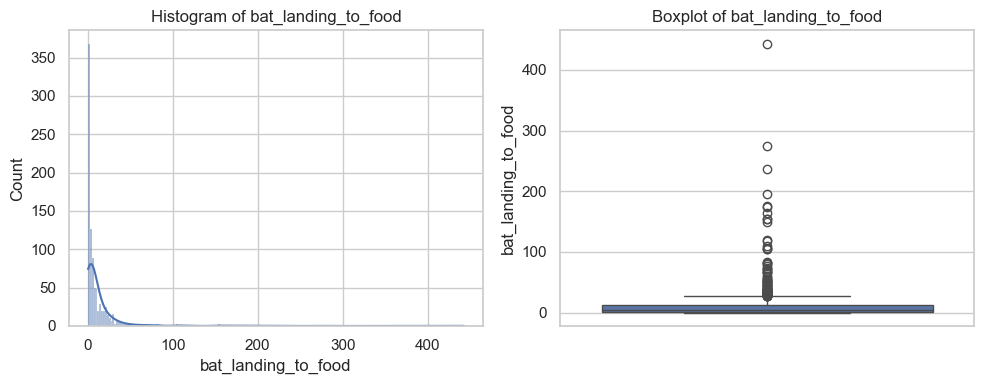


seconds_after_rat_arrival:
  Mean: 282.79, Median: 206.00, Mode: 22.00
  Std Dev: 241.09, Range: 949.00, Variance: 58125.62, IQR: 358.00
  Skewness: 0.92 (Right-skewed)


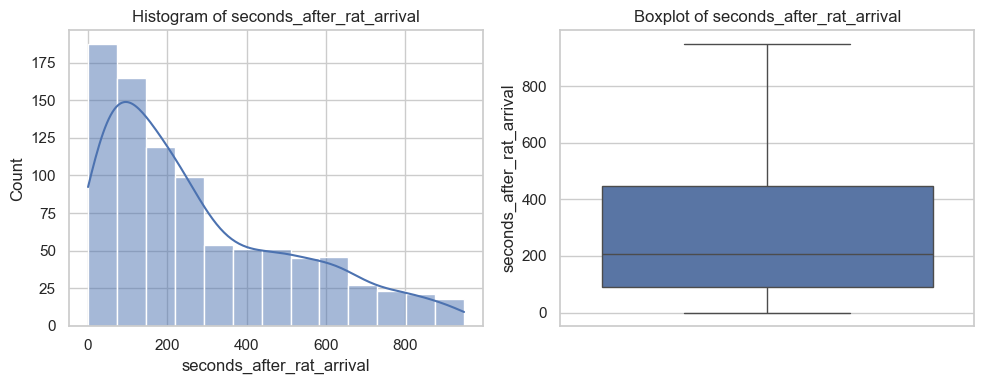


hours_after_sunset:
  Mean: 5.53, Median: 5.63, Mode: 3.17
  Std Dev: 2.42, Range: 12.35, Variance: 5.83, IQR: 3.63
  Skewness: -0.17 (Symmetric)


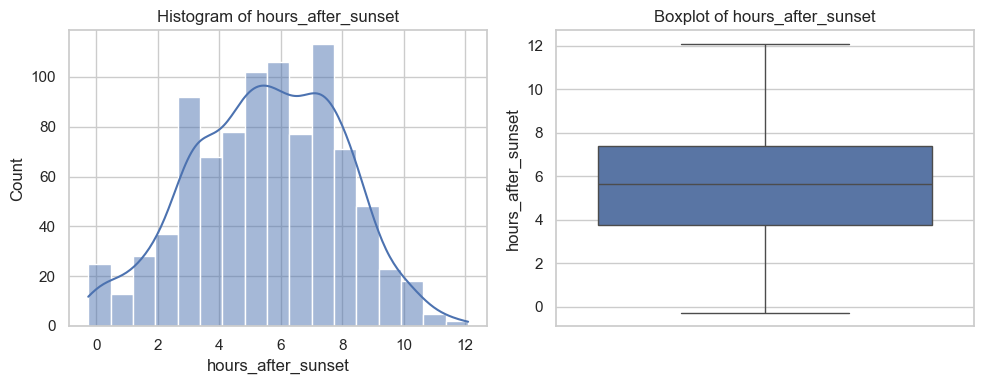


Descriptive Analysis for dataset2:

bat_landing_number:
  Mean: 32.08, Median: 27.00, Mode: 2.00
  Std Dev: 25.61, Range: 178.00, Variance: 656.10, IQR: 37.00
  Skewness: 1.06 (Right-skewed)


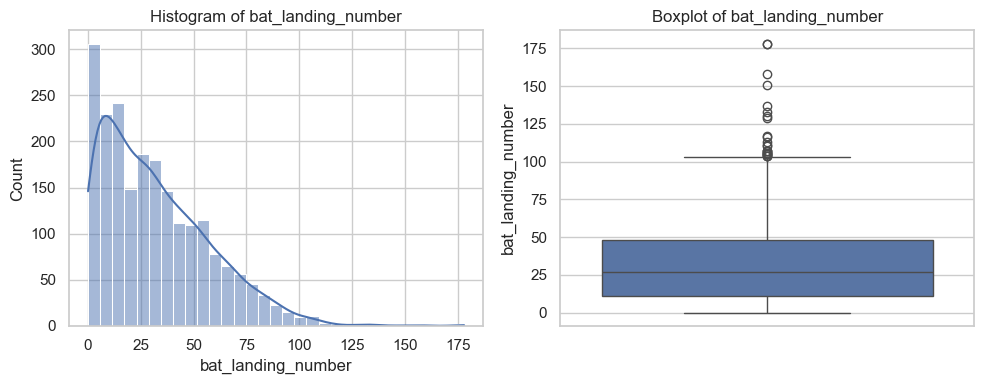


food_availability:
  Mean: 2.45, Median: 2.95, Mode: 3.00
  Std Dev: 1.22, Range: 4.00, Variance: 1.48, IQR: 1.14
  Skewness: -0.53 (Left-skewed)


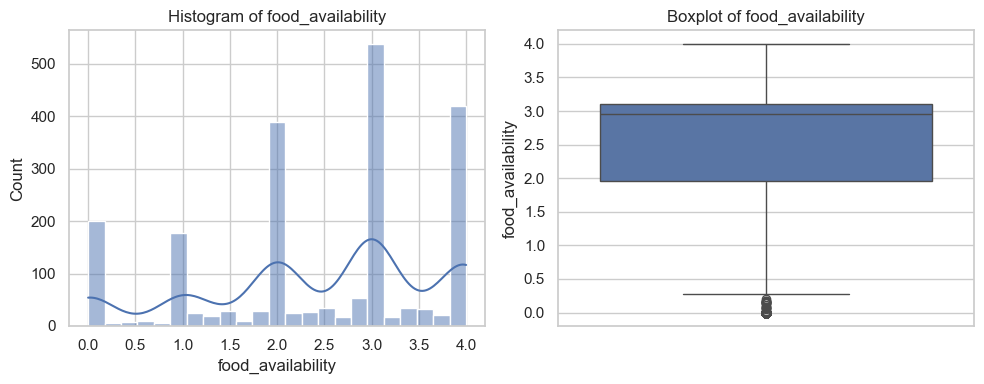


rat_minutes:
  Mean: 1.99, Median: 0.00, Mode: 0.00
  Std Dev: 6.79, Range: 120.00, Variance: 46.15, IQR: 0.16
  Skewness: 8.62 (Right-skewed)


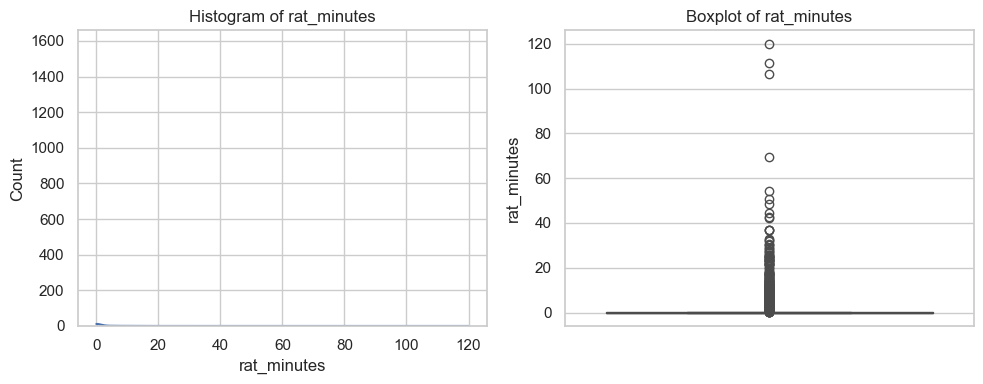


rat_arrival_number:
  Mean: 0.44, Median: 0.00, Mode: 0.00
  Std Dev: 1.02, Range: 17.00, Variance: 1.04, IQR: 1.00
  Skewness: 4.61 (Right-skewed)


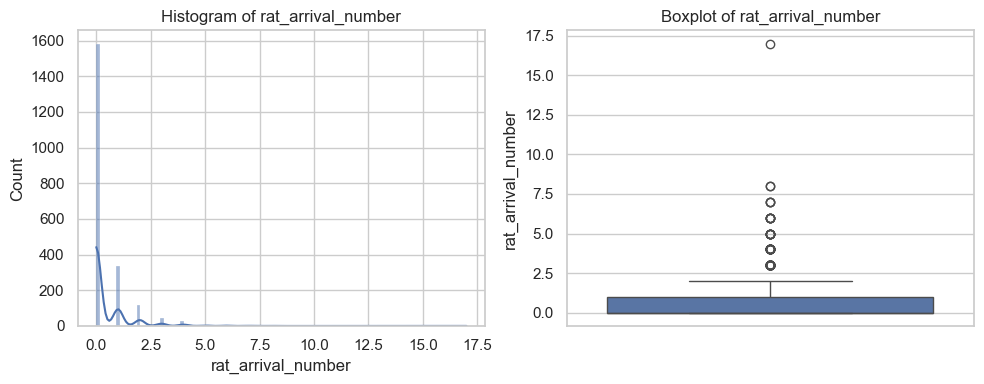

In [194]:
 ##Loop through datasets and variables to compute descriptive statistics
for dataset_name, vars_list in quant_vars.items():
    data = merged_df if dataset_name == 'dataset1' else dataset2
    print(f"\nDescriptive Analysis for {dataset_name}:")
    for var in vars_list:
        # Use rat_present for seconds_after_rat_arrival, as it is only relevant when rats are present
        if var == 'seconds_after_rat_arrival':
            values = rat_present[var].dropna()
        else:
            values = data[var].dropna()
        
        # Compute measures of center: mean, median, mode
        mean_val = values.mean()
        median_val = values.median()
        mode_val = values.mode()[0] if not values.mode().empty else np.nan
        
        # Compute dispersion: std, range, variance, IQR
        std_val = values.std()
        range_val = values.max() - values.min()
        variance_val = values.var()
        iqr_val = np.percentile(values, 75) - np.percentile(values, 25)
        
        # Compute shape: skewness to determine if symmetric, right-skewed, or left-skewed
        skewness = skew(values, nan_policy='omit')
        shape = 'Symmetric' if abs(skewness) < 0.5 else 'Right-skewed' if skewness > 0.5 else 'Left-skewed'
        
        # Print statistics for the variable
        print(f"\n{var}:")
        print(f"  Mean: {mean_val:.2f}, Median: {median_val:.2f}, Mode: {mode_val:.2f}")
        print(f"  Std Dev: {std_val:.2f}, Range: {range_val:.2f}, Variance: {variance_val:.2f}, IQR: {iqr_val:.2f}")
        print(f"  Skewness: {skewness:.2f} ({shape})")
        
        # Visualize distribution with histogram (with KDE) and boxplot
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(values, kde=True)
        plt.title(f'Histogram of {var}')
        plt.subplot(1, 2, 2)
        sns.boxplot(y=values)
        plt.title(f'Boxplot of {var}')
        plt.tight_layout()
        plt.show()